In [0]:
#Mounting my google drive

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import matplotlib.pyplot as plt
# from PIL import Image
import PIL
import glob
from scipy.io import loadmat
import tarfile
import scipy.io
import numpy as np
import cv2 as cv
import os
import shutil
import random
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
!pip install nuscenes_devkit

In [0]:
# Extracting training images 
!tar xvf gdrive/My\ Drive/emergency_vehicle/v1.0-trainval01_blobs.tgz 

In [0]:
from nuscenes.nuscenes import NuScenes

nusc = NuScenes(version='v1.0-trainval', dataroot='gdrive/My Drive/emergency_vehicle/', verbose=True)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 75.1 seconds.
Reverse indexing ...
Done reverse indexing in 13.2 seconds.


In [0]:
nusc.list_categories()

Category stats for split v1.0-trainval:
animal                      n=  787, width= 0.37±0.13, len= 0.86±0.36, height= 0.60±0.20, lw_aspect= 2.35±0.69
human.pedestrian.adult      n=208240, width= 0.67±0.13, len= 0.73±0.19, height= 1.77±0.18, lw_aspect= 1.11±0.26
human.pedestrian.child      n= 2066, width= 0.51±0.14, len= 0.53±0.15, height= 1.38±0.25, lw_aspect= 1.05±0.23
human.pedestrian.constructi n= 9161, width= 0.72±0.20, len= 0.71±0.20, height= 1.74±0.30, lw_aspect= 1.02±0.29
human.pedestrian.personal_m n=  395, width= 0.62±0.12, len= 1.18±0.31, height= 1.71±0.27, lw_aspect= 1.98±0.64
human.pedestrian.police_off n=  727, width= 0.73±0.14, len= 0.69±0.13, height= 1.83±0.14, lw_aspect= 0.97±0.18
human.pedestrian.stroller   n= 1072, width= 0.63±0.13, len= 0.95±0.27, height= 1.17±0.15, lw_aspect= 1.58±0.68
human.pedestrian.wheelchair n=  503, width= 0.77±0.10, len= 1.09±0.23, height= 1.37±0.09, lw_aspect= 1.42±0.23
movable_object.barrier      n=152087, width= 2.53±0.64, len= 0.50±0.17,

In [0]:
police = []
ambulance = []
for i in range(len(nusc.sample_annotation)):
    if nusc.sample_annotation[i]['category_name'] == 'vehicle.emergency.police':
        police.append(i)
    if nusc.sample_annotation[i]['category_name'] == 'vehicle.emergency.ambulance':
        ambulance.append(i)

In [0]:
len(ambulance)

49

In [0]:
ambulance

[161503,
 161504,
 161505,
 161506,
 161507,
 161508,
 161509,
 161510,
 161511,
 161512,
 161513,
 161514,
 161515,
 161516,
 161517,
 161518,
 161519,
 161520,
 161521,
 710709,
 710710,
 710711,
 710712,
 710713,
 710714,
 710715,
 710716,
 710717,
 710718,
 710719,
 710720,
 710721,
 710722,
 710723,
 710724,
 710725,
 710726,
 710727,
 710728,
 710729,
 710730,
 710731,
 710732,
 710733,
 710734,
 710735,
 710736,
 710737,
 710738]

In [0]:
!python --version

Python 3.6.7


In [0]:
#!pip install nuscenes_utils.geometry_utils

  ERROR: Could not find a version that satisfies the requirement nuscenes_utils.geometry_utils (from versions: none)
ERROR: No matching distribution found for nuscenes_utils.geometry_utils


In [0]:
#from nuscenes_utils.nuscenes import NuScenes

ModuleNotFoundError: ignored

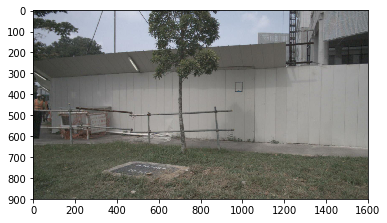

In [0]:
#from nuscenes_utils.geometry_utils import view_points, box_in_image, quaternion_slerp, BoxVisibility
from PIL import Image
import matplotlib.pyplot as plt
def render_annotation(nusc, anntoken):
        ann_record = nusc.get('sample_annotation', anntoken)
        sample_record = nusc.get('sample', ann_record['sample_token'])
        assert 'LIDAR_TOP' in sample_record['data'].keys(), 'No LIDAR_TOP in data, cant render'
        cams = [key for key in sample_record['data'].keys() if 'CAM' in key]
        for cam in cams:
            _, boxes, _ = nusc.get_sample_data(sample_record['data'][cam], selected_anntokens=[anntoken])
            if len(boxes) > 0:
                break  # We found an image that matches. Let's abort.
        assert len(boxes) > 0, "Could not find image where annotation if visible. Try using e.g. BoxVisibility.ANY."
        assert len(boxes) < 2, "Found multiple annotations. Something is wrong!"
        cam = sample_record['data'][cam]
        data_path, boxes, camera_intrinsic = nusc.get_sample_data(cam)
        return data_path

data_path = render_annotation(nusc,nusc.sample_annotation[0]['token'])

im = Image.open(data_path)
plt.imshow(im)

In [0]:
police_image_list = set()
dst_folder1 = 'gdrive/My Drive/dataset/police/'
ambulance_image_list = set()
dst_folder2 = 'gdrive/My Drive/dataset/ambulance/'
if not os.path.exists(dst_folder1):
  os.makedirs(dst_folder1)
if not os.path.exists(dst_folder2):
  os.makedirs(dst_folder2)
for i in police:
    data_path = render_annotation(nusc,nusc.sample_annotation[i]['token'])
    !cp $data_path $dst_folder1
    police_image_list.add(data_path)

for i in ambulance:
    data_path = render_annotation(nusc,nusc.sample_annotation[i]['token'])
    !cp $data_path $dst_folder2
    ambulance_image_list.add(data_path)

cp: target 'Drive/dataset/police/' is not a directory
cp: target 'Drive/dataset/police/' is not a directory
cp: target 'Drive/dataset/police/' is not a directory


KeyboardInterrupt: ignored

In [0]:
ambulance_image_list

set()

gdrive/My Drive/fellowship/emergency_vehicle/samples/CAM_FRONT_RIGHT/n008-2018-08-01-15-16-36-0400__CAM_FRONT_RIGHT__1533151061520482.jpg
gdrive/My Drive/fellowship/emergency_vehicle/samples/CAM_FRONT_RIGHT/n008-2018-08-01-15-16-36-0400__CAM_FRONT_RIGHT__1533151061520482.jpg
gdrive/My Drive/fellowship/emergency_vehicle/samples/CAM_FRONT_RIGHT/n008-2018-08-01-15-16-36-0400__CAM_FRONT_RIGHT__1533151061520482.jpg
gdrive/My Drive/fellowship/emergency_vehicle/samples/CAM_FRONT_RIGHT/n008-2018-08-01-15-16-36-0400__CAM_FRONT_RIGHT__1533151061520482.jpg
gdrive/My Drive/fellowship/emergency_vehicle/samples/CAM_FRONT_RIGHT/n008-2018-08-01-15-16-36-0400__CAM_FRONT_RIGHT__1533151061520482.jpg
gdrive/My Drive/fellowship/emergency_vehicle/samples/CAM_FRONT_RIGHT/n008-2018-08-01-15-16-36-0400__CAM_FRONT_RIGHT__1533151061520482.jpg
gdrive/My Drive/fellowship/emergency_vehicle/samples/CAM_FRONT_RIGHT/n008-2018-08-01-15-16-36-0400__CAM_FRONT_RIGHT__1533151061520482.jpg
gdrive/My Drive/fellowship/emergen

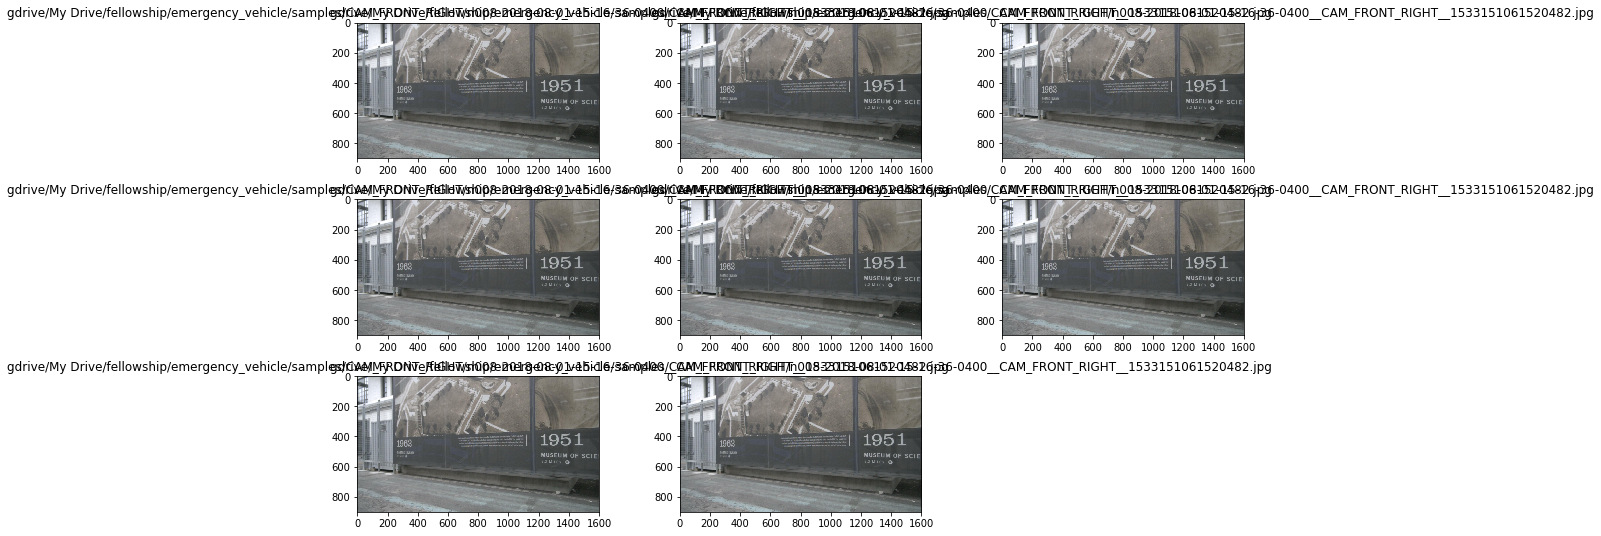

In [0]:
count=0
fig=plt.figure(figsize=(16, 9))
for filename in police_image_list:
    img=PIL.Image.open(filename)
    count = count+1
    fig.add_subplot(3, 3, count)
    fig.subplots_adjust(hspace=0.3,wspace=0.3)
    plt.imshow(img)
    plt.title(filename)
    print (filename)
    if count==9:
      break

In [0]:
police_image_list

{'gdrive/My Drive/fellowship/emergency_vehicle/samples/CAM_BACK_RIGHT/n008-2018-05-21-11-06-59-0400__CAM_BACK_RIGHT__1526915667927813.jpg',
 'gdrive/My Drive/fellowship/emergency_vehicle/samples/CAM_FRONT_RIGHT/n008-2018-05-21-11-06-59-0400__CAM_FRONT_RIGHT__1526915662019956.jpg',
 'gdrive/My Drive/fellowship/emergency_vehicle/samples/CAM_FRONT_RIGHT/n008-2018-05-21-11-06-59-0400__CAM_FRONT_RIGHT__1526915662919956.jpg',
 'gdrive/My Drive/fellowship/emergency_vehicle/samples/CAM_FRONT_RIGHT/n008-2018-05-21-11-06-59-0400__CAM_FRONT_RIGHT__1526915663419956.jpg',
 'gdrive/My Drive/fellowship/emergency_vehicle/samples/CAM_FRONT_RIGHT/n008-2018-05-21-11-06-59-0400__CAM_FRONT_RIGHT__1526915664419956.jpg',
 'gdrive/My Drive/fellowship/emergency_vehicle/samples/CAM_FRONT_RIGHT/n008-2018-05-21-11-06-59-0400__CAM_FRONT_RIGHT__1526915664919956.jpg',
 'gdrive/My Drive/fellowship/emergency_vehicle/samples/CAM_FRONT_RIGHT/n008-2018-05-21-11-06-59-0400__CAM_FRONT_RIGHT__1526915665919956.jpg',
 'gdrive

In [0]:
os.getcwd()

'/content'